#Regime Detection Assigment

In [1]:
!pip install -q umap-learn


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import files
uploaded = files.upload()


Saving Data-20250411T052850Z-001.zip to Data-20250411T052850Z-001.zip


In [4]:
import zipfile
import os

zip_file = next(iter(uploaded))
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("data")

os.listdir("data/Data/depth20_1000ms")


['BNBFDUSD_20250315.txt',
 'BNBFDUSD_20250317.txt',
 'BNBFDUSD_20250314.txt',
 'BNBFDUSD_20250316.txt']

In [5]:
depth_df = pd.read_csv("data/Data/depth20_1000ms/BNBFDUSD_20250314.txt")
trade_df = pd.read_csv("data/Data/aggTrade/BNBFDUSD_20250314.txt")
depth_df['timestamp'] = pd.to_datetime(depth_df['Time'].str.split('+').str[0].str.strip())
trade_df['timestamp'] = pd.to_datetime(trade_df['Time'].str.split('+').str[0].str.strip())
trade_df.set_index('timestamp', inplace=True)


In [6]:
def extract_features_from_orderbook(df):
    features = []
    for _, row in df.iterrows():
        bid_prices = np.array([row[f'BidPriceL{i}'] for i in range(1, 21)])
        ask_prices = np.array([row[f'AskPriceL{i}'] for i in range(1, 21)])
        bid_qtys = np.array([row[f'BidQtyL{i}'] for i in range(1, 21)])
        ask_qtys = np.array([row[f'AskQtyL{i}'] for i in range(1, 21)])

        spread = ask_prices[0] - bid_prices[0]
        imbalance_lvl1 = (bid_qtys[0] - ask_qtys[0]) / (bid_qtys[0] + ask_qtys[0] + 1e-6)
        microprice = (bid_prices[0] * ask_qtys[0] + ask_prices[0] * bid_qtys[0]) / (bid_qtys[0] + ask_qtys[0] + 1e-6)
        cum_bid_qty = np.sum(bid_qtys)
        cum_ask_qty = np.sum(ask_qtys)
        depth_slope_bid = bid_qtys[0] - bid_qtys[-1]
        depth_slope_ask = ask_qtys[0] - ask_qtys[-1]

        features.append([
            spread, imbalance_lvl1, microprice,
            cum_bid_qty, cum_ask_qty, depth_slope_bid, depth_slope_ask
        ])
    return pd.DataFrame(features, columns=[
        'spread', 'imbalance_lvl1', 'microprice',
        'cum_bid_qty', 'cum_ask_qty', 'depth_slope_bid', 'depth_slope_ask'
    ])


In [7]:
orderbook_features = extract_features_from_orderbook(depth_df)
orderbook_features['timestamp'] = depth_df['timestamp'].values

volume_df = trade_df.resample('1S').agg({
    'Quantity': 'sum',
    'Price': 'mean',
    'IsMarketMaker': lambda x: (x == False).sum() - (x == True).sum()
}).rename(columns={'Quantity': 'total_volume', 'Price': 'avg_price', 'IsMarketMaker': 'volume_imbalance'})

volume_df['cum_volume_10s'] = volume_df['total_volume'].rolling(window=10).sum()
volume_df['cum_volume_30s'] = volume_df['total_volume'].rolling(window=30).sum()
volume_df['vwap_shift'] = volume_df['avg_price'].diff(periods=5)
volume_df.dropna(inplace=True)
volume_df.reset_index(inplace=True)

merged_features = pd.merge_asof(orderbook_features.sort_values('timestamp'),
                                 volume_df.sort_values('timestamp'),
                                 on='timestamp')
merged_features.dropna(inplace=True)
merged_features.set_index('timestamp', inplace=True)


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_features)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)


In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_kmeans = kmeans.fit_predict(X_pca)
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(X_pca)


KMeans Silhouette: 0.2636471403176082
KMeans DB Index: 1.203417629948262
GMM Silhouette: 0.2789532005450643
GMM DB Index: 2.155330625651953


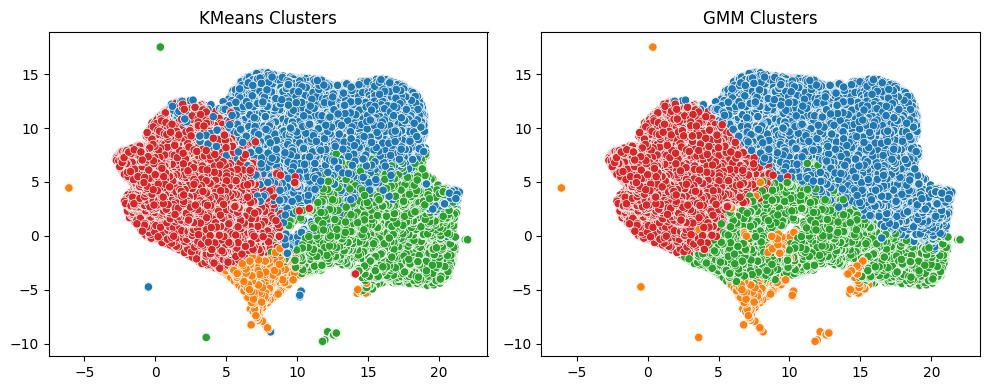

In [10]:
print("KMeans Silhouette:", silhouette_score(X_pca, labels_kmeans))
print("KMeans DB Index:", davies_bouldin_score(X_pca, labels_kmeans))
print("GMM Silhouette:", silhouette_score(X_pca, labels_gmm))
print("GMM DB Index:", davies_bouldin_score(X_pca, labels_gmm))

X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_pca)
plt.figure(figsize=(10, 4))
for i, (labels, title) in enumerate([(labels_kmeans, 'KMeans'), (labels_gmm, 'GMM')]):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='tab10', legend=None)
    plt.title(f'{title} Clusters')
plt.tight_layout()
plt.show()


In [11]:
merged_features['regime_kmeans'] = labels_kmeans
merged_features.groupby('regime_kmeans').mean()


,spread,imbalance_lvl1,microprice,cum_bid_qty,cum_ask_qty,depth_slope_bid,depth_slope_ask,total_volume,avg_price,volume_imbalance,cum_volume_10s,cum_volume_30s,vwap_shift
regime_kmeans,,,,,,,,,,,,,
0,0.046570,-0.045633,580.390920,59.171445,51.456510,-3.984632,-1.654265,2.236475,580.392236,-0.995485,15.589993,48.213677,-0.009277
1,0.069526,-0.013666,582.623128,62.581916,55.824677,-2.508416,-1.956381,19.082420,582.623443,-0.802742,116.915922,247.794412,-0.004405
2,0.057475,0.025593,577.714467,53.311909,67.312502,-1.878590,-3.428914,4.488552,577.711778,-0.111489,29.994871,82.599275,0.007520
3,0.054754,0.002937,584.863487,53.619451,57.019153,-2.199062,-2.429185,3.272311,584.863012,0.033406,25.758232,77.802480,0.007591


**Regime Change Insights**

In [12]:
regimes = merged_features['regime_kmeans'].values
transitions = {}

for i in range(len(regimes) - 1):
    key = (regimes[i], regimes[i + 1])
    transitions[key] = transitions.get(key, 0) + 1

from collections import defaultdict
transition_matrix = defaultdict(dict)

for (prev, curr), count in transitions.items():
    transition_matrix[prev][curr] = count

transition_df = pd.DataFrame(transition_matrix).fillna(0).astype(int).T
transition_prob = transition_df.div(transition_df.sum(axis=1), axis=0)
transition_prob


,2,1,0,3
2,0.852093,0.007187,0.139507,0.001214
1,0.053599,0.811468,0.012777,0.122156
0,0.082545,0.002605,0.884779,0.030071
3,0.000779,0.013608,0.039562,0.946051


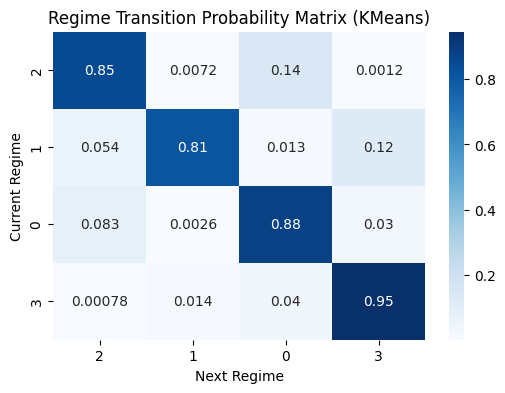

In [13]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(transition_prob, annot=True, cmap='Blues')
plt.title("Regime Transition Probability Matrix (KMeans)")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()